In [1]:
# pip install sodapy

In [2]:
# pip install us

In [3]:
import pandas as pd
from sodapy import Socrata
import requests as rq
import matplotlib.pyplot as plt
import us

In [4]:
# Enrollment data by state
# Source: https://www.kff.org/health-reform/state-indicator/medicaid-expansion-enrollment/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

df_medicaid = pd.read_csv('data/KFF_medicaid_enrollment.csv', header=2).loc[:51] # get rid of junk rows
df_medicaid = df_medicaid.loc[df_medicaid['Location'] != 'United States'] # just states & DC
df_medicaid = df_medicaid.rename(columns={
    'Location':'state',
    'Expanded by September 30th, 2022':'expanded_medicaid'
})
df_medicaid['expanded_medicaid'] = df_medicaid['expanded_medicaid'].replace({'Yes': True, 'No': False})
df_medicaid = df_medicaid[['state', 'expanded_medicaid']]

df_medicaid.head()

,state,expanded_medicaid
1,Alabama,False
2,Alaska,True
3,Arizona,True
4,Arkansas,True
5,California,True


In [5]:
# # Life expectancy by state (2010-2015)
# # Docs: https://dev.socrata.com/foundry/data.cdc.gov/5h56-n989

# client = Socrata("data.cdc.gov", None)
# data = client.get("5h56-n989", where='county_name = "(blank)"')
# df_life_exp_src = pd.DataFrame.from_records(data)

# # df_life_exp = df_life_exp.set_index('state_name')

# df_life_exp = df_life_exp_src.copy()
# df_life_exp = df_life_exp.drop('county_name', axis=1)
# df_life_exp = df_life_exp.rename(columns={'le':'LE'})
# df_life_exp[['LE Range Lower', 'LE Range Upper']] = df_life_exp['le_range'].str.split('-', expand=True)
# df_life_exp = df_life_exp.drop(columns=['le_range', 'se_le'])

# df_life_exp['LE'] = df_life_exp['LE'].astype(float)
# df_life_exp['LE Range Lower'] = df_life_exp['LE Range Lower'].astype(float)
# df_life_exp['LE Range Upper'] = df_life_exp['LE Range Upper'].astype(float)

# df_life_exp.head()


In [6]:
df_life_exp = pd.read_csv('data/cdc_life_exp.csv')
df_life_exp = df_life_exp.rename(columns={'STATE':'state_abbr', 'RATE':'life_exp'})

df_life_exp = df_life_exp.loc[df_life_exp['YEAR'] == max(df_life_exp['YEAR'])]
state_names = []
for s in df_life_exp['state_abbr']:
    state_names.append(us.states.lookup(s).name)
df_life_exp['state'] = state_names
df_life_exp = df_life_exp[['state', 'life_exp']]
df_life_exp = df_life_exp.sort_values('life_exp').reset_index().drop(columns='index')

df_life_exp.head()

,state,life_exp
0,Mississippi,71.9
1,West Virginia,72.8
2,Louisiana,73.1
3,Alabama,73.2
4,Kentucky,73.5


In [7]:
# API endpoint URL for poverty rate data by state
url = 'https://api.census.gov/data/timeseries/poverty/saipe?get=NAME,SAEPOVRTALL_PT&for=state:*&time=2021'

response = rq.get(url)
data = response.json()
cols = data[0]

df_poverty = pd.DataFrame(data[1:], columns=cols)
df_poverty = df_poverty.rename(columns={'NAME':'state',
                                        'SAEPOVRTALL_PT':'poverty_rate',
                                        'state':'state_num'})
df_poverty['poverty_rate'] = df_poverty['poverty_rate'].astype(float)
df_poverty = df_poverty.sort_values('poverty_rate', ascending=False).reset_index()[['state','poverty_rate']]

df_poverty.head()

,state,poverty_rate
0,Louisiana,19.5
1,Mississippi,19.2
2,New Mexico,17.7
3,District of Columbia,16.8
4,West Virginia,16.8


In [8]:
def make_plot(df, y_col, y_lbl, title):
    df = df.merge(df_medicaid, how='inner', on='state')
    
    plt.figure(figsize=(10, 5))
    for i in range(len(df)):
        if df.loc[i, 'expanded_medicaid']:
            plt.scatter(i, df[y_col][i], c='#30b5f2', marker='o')
        else:
            plt.scatter(i, df[y_col][i], c='#eb4034', marker='D')
    plt.xticks(range(len(df)), df['state'], rotation='vertical')

    plt.xlabel('State')
    plt.ylabel(y_lbl)
    plt.title(title)
    plt.axvline(x=len(df)/2, color='green', linestyle='-')
    plt.show()

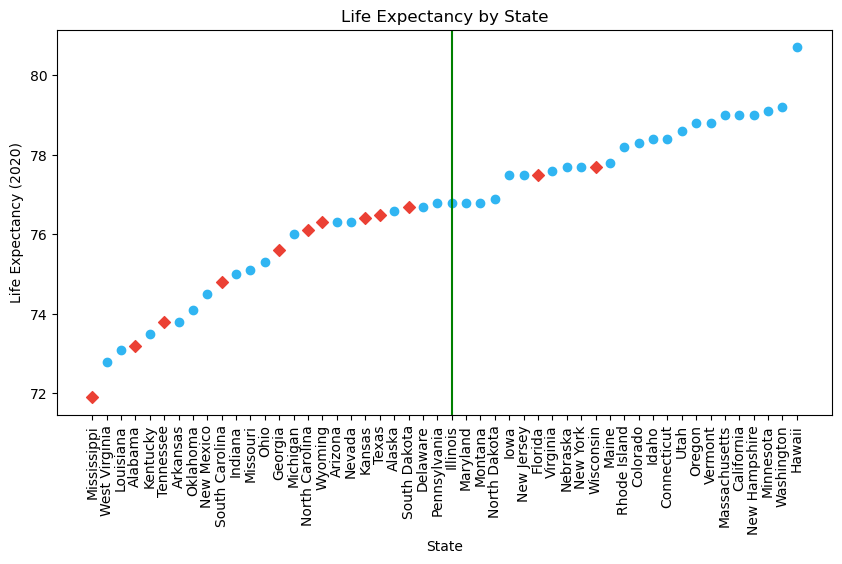

In [9]:
make_plot(df_life_exp, 'life_exp', 'Life Expectancy (2020)', 'Life Expectancy by State')

In [10]:
make_plot(df_poverty, 'poverty_rate', 'Life Expectancy (2020)', 'Life Expectancy by State')